# Webscraping COVID-19 data 

## Import necessary modules

In [1]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

## Scrape the COVID-19 table from Wikipedia

In [2]:
url = 'https://en.wikipedia.org/wiki/COVID-19_pandemic_by_country_and_territory'

# get response
response = requests.get(url)

# check the response of the page
response

<Response [200]>

In [3]:
# create BeautifulSoup object
soup = BeautifulSoup(response.text, 'html.parser')


# extract the covid-19 data table
table_id = 'thetable'

covid_table = soup.find('table', attrs = {'id': table_id})

## Read Covid-19 table into pandas dataframe

In [4]:
covid_df = pd.read_html(str(covid_table), header = 0)[0]
covid_df

,Location[a],Location[a].1,Cases[b],Deaths[c],Recov.[d],Ref.
0,NaN,World[e],84673991,1837649,47694365,[4]
1,NaN,United States[f],20596260,353309,9223561,[15]
2,NaN,India,10305788,149218,9906387,[16]
3,NaN,Brazil,7716405,195742,6769420,[17][18]
4,NaN,Russia[g],3236787,58506,2618882,[19]
...,...,...,...,...,...,...
235,NaN,Samoa,2,0,0,[352]
236,NaN,Vanuatu,1,0,1,[353]
237,NaN,Tanzania[be],No data,No data,No data,[355][356]
238,As of 3 January 2021 (UTC) · History of cases ...,As of 3 January 2021 (UTC) · History of cases ...,As of 3 January 2021 (UTC) · History of cases ...,As of 3 January 2021 (UTC) · History of cases ...,As of 3 January 2021 (UTC) · History of cases ...,As of 3 January 2021 (UTC) · History of cases ...


## Drop the first and last column and last three rows

In [5]:
covid_df = covid_df.drop(covid_df.columns[[0, 5]], axis = 1)
covid_df = covid_df.drop([237, 238, 239])
covid_df

,Location[a].1,Cases[b],Deaths[c],Recov.[d]
0,World[e],84673991,1837649,47694365
1,United States[f],20596260,353309,9223561
2,India,10305788,149218,9906387
3,Brazil,7716405,195742,6769420
4,Russia[g],3236787,58506,2618882
...,...,...,...,...
232,Marshall Islands,4,0,2
233,Wallis and Futuna,4,0,1
234,American Samoa,3,0,0
235,Samoa,2,0,0


## Rename the columns of the dataframe

In [6]:
# drop the first row containing world information
covid_df = covid_df.iloc[1:]

covid_df.columns = ['country', 'cases', 'deaths', 'recovered']
covid_df.head()

,country,cases,deaths,recovered
1,United States[f],20596260,353309,9223561
2,India,10305788,149218,9906387
3,Brazil,7716405,195742,6769420
4,Russia[g],3236787,58506,2618882
5,France[h],2643239,64921,195174


## Remove the square bracket from the country names

In [7]:
covid_df.loc[:, 'country'] = covid_df['country'].str.replace(r"\[.*\]", "")
covid_df.head()

C:\Users\ankit\Anaconda3\lib\site-packages\pandas\core\indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,country,cases,deaths,recovered
1,United States,20596260,353309,9223561
2,India,10305788,149218,9906387
3,Brazil,7716405,195742,6769420
4,Russia,3236787,58506,2618882
5,France,2643239,64921,195174


## Replace No data entry in recovered column with zeros

In [8]:
covid_df[covid_df.recovered == 'No data']

,country,cases,deaths,recovered
6,United Kingdom,2599789,74570,No data
9,Spain,1928265,50837,No data
19,Netherlands,813765,11565,No data
22,Belgium,649169,19644,No data
32,Sweden,437379,8727,No data
37,Serbia,341904,3288,No data
65,Greece,139709,4921,No data
70,Slovenia,124343,2774,No data
86,Puerto Rico,73162,1526,No data
205,Greg Mortimer,128,1,No data


In [9]:
covid_df.loc[:, 'recovered'] = covid_df.recovered.replace('No data', '0')
covid_df[covid_df.recovered == 'No data']

C:\Users\ankit\Anaconda3\lib\site-packages\pandas\core\indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,country,cases,deaths,recovered


## Change the data types from object to float

In [10]:
# get basic information about the dataframe
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 236 entries, 1 to 236
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   country    236 non-null    object
 1   cases      236 non-null    object
 2   deaths     236 non-null    object
 3   recovered  236 non-null    object
dtypes: object(4)
memory usage: 9.2+ KB


In [11]:
conversion_dict = {'cases': float, 'deaths': float, 'recovered': float} 
covid_df = covid_df.astype(conversion_dict) 
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 236 entries, 1 to 236
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   country    236 non-null    object 
 1   cases      236 non-null    float64
 2   deaths     236 non-null    float64
 3   recovered  236 non-null    float64
dtypes: float64(3), object(1)
memory usage: 9.2+ KB


## Drop all rows of countries with zero recorded deaths or non-numeric death data

In [12]:
covid_df = covid_df[covid_df.deaths != 0]
covid_df.shape

(206, 4)

## Create a new column called cases_per_deaths

In [13]:
covid_df['cases_per_deaths'] = round(covid_df['cases'] / covid_df['deaths'], 2)
covid_df

,country,cases,deaths,recovered,cases_per_deaths
1,United States,20596260.0,353309.0,9223561.0,58.30
2,India,10305788.0,149218.0,9906387.0,69.07
3,Brazil,7716405.0,195742.0,6769420.0,39.42
4,Russia,3236787.0,58506.0,2618882.0,55.32
5,France,2643239.0,64921.0,195174.0,40.71
...,...,...,...,...,...
212,Fiji,49.0,2.0,44.0,24.50
217,Sahrawi Arab DR,31.0,3.0,27.0,10.33
226,Montserrat,13.0,1.0,12.0,13.00
227,MS Zaandam,13.0,4.0,0.0,3.25


## Sort the DataFrame based on the highest number of cases_per_deaths 

In [14]:
covid_df.sort_values('cases_per_deaths', ascending = False).head(20)

,country,cases,deaths,recovered,cases_per_deaths
89,Singapore,58662.0,29.0,58476.0,2022.83
178,Mongolia,1215.0,1.0,830.0,1215.00
180,USS Theodore Roosevelt,1102.0,1.0,751.0,1102.00
61,Qatar,144437.0,245.0,141808.0,589.54
177,Eritrea,1320.0,3.0,676.0,440.00
186,Burundi,760.0,2.0,687.0,380.00
165,Gibraltar,2212.0,6.0,1249.0,368.67
46,United Arab Emirates,213231.0,679.0,189709.0,314.04
124,Botswana,12340.0,40.0,11627.0,308.50
118,Maldives,13804.0,48.0,13149.0,287.58


## Comments on cases_per_death column :
- Countries with high value of cases_per_deaths indicate **low mortality rate**
- **Singapore**, **Mangolia**, **USS Theodore Roosevelt** have very low death rate despite large number of covid cases.

- While the countries like **Guinea**, **Cayman Islands** have **high mortality rate** when compared with **Singapore**. 

# Part 2 - Exploring prediction algorithms on COVID-19 data 

In [15]:
# load the csv file from the url
url_csv = 'https://covid.ourworldindata.org/data/ecdc/total_deaths.csv'

df = pd.read_csv(url_csv)

# print the head of the dataframe
df.head()

,date,World,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,...,Uzbekistan,Vanuatu,Vatican,Venezuela,Vietnam,Wallis and Futuna,Western Sahara,Yemen,Zambia,Zimbabwe
0,2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Check the end of the dataframe
df.tail()

,date,World,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,...,Uzbekistan,Vanuatu,Vatican,Venezuela,Vietnam,Wallis and Futuna,Western Sahara,Yemen,Zambia,Zimbabwe
330,2020-11-25,1410788.0,1725.0,735.0,2309.0,76.0,337.0,NaN,4.0,37432.0,...,605.0,NaN,NaN,876.0,35.0,NaN,1.0,609.0,357.0,274.0
331,2020-11-26,1423371.0,1737.0,743.0,2329.0,76.0,338.0,NaN,4.0,37701.0,...,606.0,NaN,NaN,880.0,35.0,NaN,1.0,611.0,357.0,274.0
332,2020-11-27,1434009.0,1737.0,753.0,2352.0,76.0,340.0,NaN,4.0,37941.0,...,607.0,NaN,NaN,880.0,35.0,NaN,1.0,612.0,357.0,274.0
333,2020-11-28,1444342.0,1752.0,771.0,NaN,76.0,NaN,NaN,4.0,38203.0,...,607.0,NaN,NaN,884.0,35.0,NaN,1.0,614.0,357.0,275.0
334,2020-11-29,1453531.0,1763.0,787.0,2393.0,76.0,345.0,NaN,4.0,38309.0,...,607.0,NaN,NaN,888.0,35.0,NaN,1.0,615.0,357.0,275.0


In [17]:
# get basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335 entries, 0 to 334
Columns: 216 entries, date to Zimbabwe
dtypes: float64(215), object(1)
memory usage: 565.4+ KB


In [18]:
# get basic description about the dataset
pd.set_option('display.max_rows', 220)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
World,324.0,521517.716049,445750.079365,1.0,42277.50,459647.5,899647.25,1453531.0
Afghanistan,251.0,921.314741,617.389971,1.0,218.50,1269.0,1453.00,1763.0
Albania,263.0,208.802281,210.014101,1.0,31.00,113.0,370.00,787.0
Algeria,261.0,1108.597701,663.709629,1.0,542.00,1087.0,1698.00,2393.0
Andorra,248.0,51.854839,14.107278,3.0,51.00,52.0,53.00,76.0
Angola,244.0,97.520492,110.366932,2.0,4.00,44.0,172.25,345.0
Anguilla,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Antigua and Barbuda,234.0,3.021368,0.339737,2.0,3.00,3.0,3.00,4.0
Argentina,265.0,9205.105660,12170.016949,1.0,353.00,2246.0,14376.00,38309.0
Armenia,248.0,674.564516,552.107779,1.0,109.25,721.0,952.50,2142.0


### DataFrame has lots of null values

In [19]:
# convert date column into pandas datetime object
df.date = pd.to_datetime(df.date)

# check the datatype of the date column
df.date.dtype

dtype('<M8[ns]')

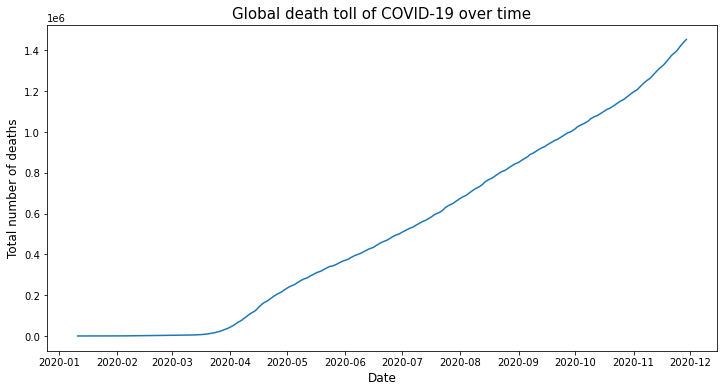

In [20]:
plt.figure(figsize = (12, 6))
plt.plot(df.date, df.World)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Total number of deaths', fontsize = 12)
plt.title('Global death toll of COVID-19 over time', fontsize = 15);

### Check the null values in the dataframe

In [21]:
df.isnull().sum()

date                                  0
World                                11
Afghanistan                          84
Albania                              72
Algeria                              74
Andorra                              87
Angola                               91
Anguilla                            335
Antigua and Barbuda                 101
Argentina                            70
Armenia                              87
Aruba                               107
Australia                            61
Austria                              73
Azerbaijan                           81
Bahamas                              93
Bahrain                              77
Bangladesh                           82
Barbados                             97
Belarus                              94
Belgium                              72
Belize                               97
Benin                                99
Bermuda                              98
Bhutan                              335


## Fill null values with zero

In [22]:
df.fillna(0, inplace = True)

# check the null values 
df.isnull().sum()

date                                0
World                               0
Afghanistan                         0
Albania                             0
Algeria                             0
Andorra                             0
Angola                              0
Anguilla                            0
Antigua and Barbuda                 0
Argentina                           0
Armenia                             0
Aruba                               0
Australia                           0
Austria                             0
Azerbaijan                          0
Bahamas                             0
Bahrain                             0
Bangladesh                          0
Barbados                            0
Belarus                             0
Belgium                             0
Belize                              0
Benin                               0
Bermuda                             0
Bhutan                              0
Bolivia                             0
Bonaire Sint

## Simple Linear Regression

In [24]:
# Add extra column containing number of days
df['days'] = pd.to_datetime(df['date']).sub(pd.Timestamp('2019-12-31')).dt.days
df.head()

,date,World,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,...,Vanuatu,Vatican,Venezuela,Vietnam,Wallis and Futuna,Western Sahara,Yemen,Zambia,Zimbabwe,days
0,2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [25]:
# split the data into train and validation sets
train_x, val_x, train_y, val_y = train_test_split(df.days.values, df.World.values, test_size = 0.15, random_state = 42)
print(f'train_x shape: {train_x.shape}\ntrain_y shape: {train_y.shape}')
print(f'val_x shape: {val_x.shape}\nval_y shape: {val_y.shape}')

train_x shape: (284,)
train_y shape: (284,)
val_x shape: (51,)
val_y shape: (51,)


In [26]:
# instantiate linear regression model
lm = LinearRegression()

# fit the model on the training data
lm.fit(train_x.reshape(-1, 1), train_y.reshape(-1, 1))

# make predictions on the validation data
predictions = lm.predict(val_x.reshape(-1, 1))

# calculate the rms error on the validation data
np.sqrt(mean_squared_error(val_y.reshape(-1, 1), predictions))

93680.63245615971

In [27]:
# fit on the entire data and make predictions
lm.fit(df.days.values.reshape(-1, 1), df.World.values.reshape(-1, 1))

predictions = lm.predict(df.days.values.reshape(-1, 1))

### Plot the predictions of the model

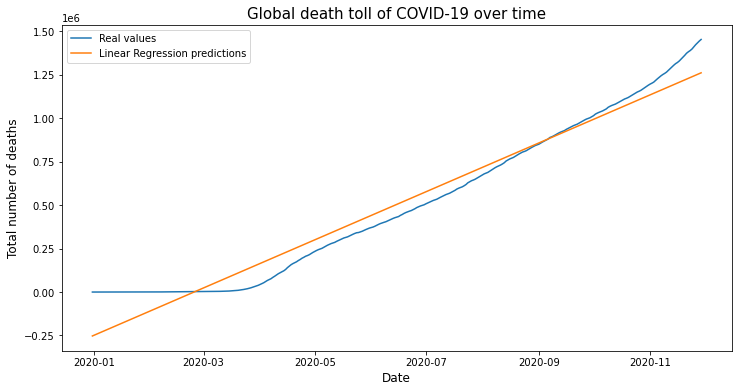

In [28]:
plt.figure(figsize = (12, 6))
plt.plot(df.date, df.World)
plt.plot(df.date, predictions)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Total number of deaths', fontsize = 12)
plt.legend(['Real values', 'Linear Regression predictions'])
plt.title('Global death toll of COVID-19 over time', fontsize = 15);

In [29]:
# Mean squared error of the linear model
mean_squared_error(df.World.values.reshape(-1, 1), predictions)

7944480123.264761

## South Korea COVID-19 Data Analysis

In [30]:
# get the index of the date 2020-11-22
df[df.date == '2020-11-22'].index[0]

327

In [31]:
# get the index of first death date in South Korea
df[df['South Korea'] == 1]['South Korea'].index[0]

52

In [32]:
# split data into train and test set
train_x = df.iloc[52:328]['days'].values.reshape(-1, 1)
train_y = df.iloc[52:328]['South Korea'].values.reshape(-1, 1)

test_x = df.iloc[328:]['days'].values.reshape(-1, 1)
test_y = df.iloc[328:]['South Korea'].values.reshape(-1, 1)

print(f'train_x shape: {train_x.shape}\ntrain_y shape: {train_y.shape}')
print(f'test_x shape: {test_x.shape}\ntest_y shape: {test_y.shape}')

train_x shape: (276, 1)
train_y shape: (276, 1)
test_x shape: (7, 1)
test_y shape: (7, 1)


### Linear Regression Model

In [33]:
# instantiate simple linear regression model
linear_model = LinearRegression()

# fit the model
linear_model.fit(train_x, train_y)

# make predictions
pred = linear_model.predict(test_x)

# Mean squared error on the test set
mean_squared_error(test_y, pred)

513.9049373570202

### GradientBoostingRegressor Model

In [34]:
model = GradientBoostingRegressor(random_state = 42, max_depth = 5)
model.fit(train_x, train_y.ravel())
preds = model.predict(test_x )
mean_squared_error(test_y, preds)

134.53088359931533

### Plot the predictions of the model for South Korea

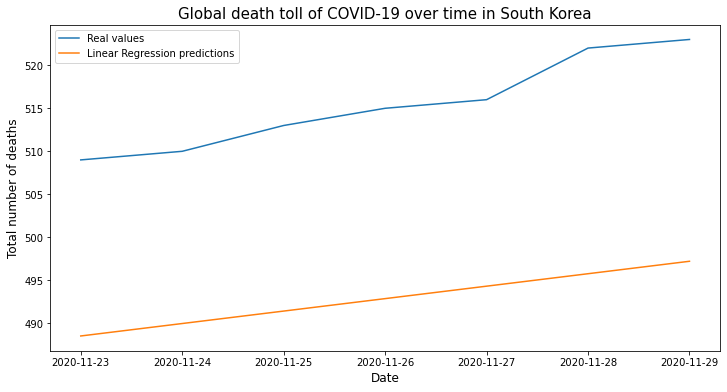

In [36]:
plt.figure(figsize = (12, 6))
plt.plot(df.date.iloc[328:], df['South Korea'].iloc[328:])
plt.plot(df.date.iloc[328:], pred)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Total number of deaths', fontsize = 12)
plt.legend(['Real values', 'Linear Regression predictions'])
plt.title('Global death toll of COVID-19 over time in South Korea', fontsize = 15);